# Overview
BigQuery ML (BigQuery machine learning) is a feature in BigQuery where data analysts can create, train, evaluate, and predict with machine learning models with minimal coding.

The Google Analytics Sample Ecommerce dataset that has millions of Google Analytics records for the Google Merchandise Store loaded into BigQuery.

Open BigQuery Console
In the Google Cloud Console, select Navigation menu > BigQuery.
The Welcome to BigQuery in the Cloud Console message box opens. This message box provides a link to the quickstart guide and lists UI updates.

Click Done.

Open Dataset:

In [ ]:
SELECT
  *
FROM
  `data-to-insights.ecommerce.web_analytics`
WHERE
  totals IS NOT NULL


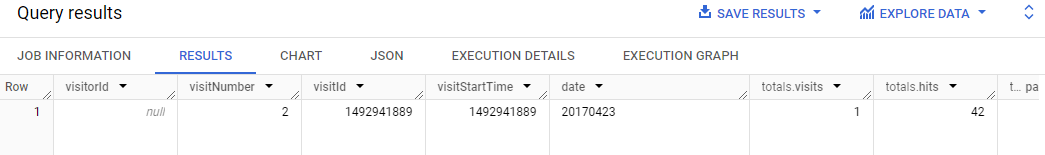

# Task 1. Explore ecommerce data

Scenario: Your data analyst team exported the Google Analytics logs for an ecommerce website into BigQuery and created a new table of all the raw ecommerce visitor session data for you to explore. Using this data, you'll try to answer a few questions.

Question: Out of the total visitors who visited our website, what % made a purchase?

Click the query Editor.
Add the following to the New Query field:

In [ ]:
#standardSQL
WITH visitors AS(
SELECT
COUNT(DISTINCT fullVisitorId) AS total_visitors
FROM `data-to-insights.ecommerce.web_analytics`
),

purchasers AS(
SELECT
COUNT(DISTINCT fullVisitorId) AS total_purchasers
FROM `data-to-insights.ecommerce.web_analytics`
WHERE totals.transactions IS NOT NULL
)

SELECT
  total_visitors,
  total_purchasers,
  total_purchasers / total_visitors AS conversion_rate
FROM visitors, purchasers

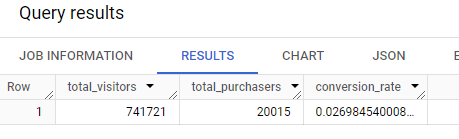

Click Run.
The result: 2.69%

Question: What are the top 5 selling products?

Add the following query in the query EDITOR, and then click Run:

In [ ]:
SELECT
  p.v2ProductName,
  p.v2ProductCategory,
  SUM(p.productQuantity) AS units_sold,
  ROUND(SUM(p.localProductRevenue/1000000),2) AS revenue
FROM `data-to-insights.ecommerce.web_analytics`,
UNNEST(hits) AS h,
UNNEST(h.product) AS p
GROUP BY 1, 2
ORDER BY revenue DESC
LIMIT 5;

The result:

| Row | v2ProductName                                       | v2ProductCategory | units_sold | revenue     |
|-----|-----------------------------------------------------|-------------------|------------|-------------|
| 1   | Nest® Learning Thermostat 3rd Gen-USA - Stainless Steel | Nest-USA          | 17651      | 870976.95   |
| 2   | Nest® Cam Outdoor Security Camera - USA             | Nest-USA          | 16930      | 684034.55   |
| 3   | Nest® Cam Indoor Security Camera - USA              | Nest-USA          | 14155      | 548104.47   |
| 4   | Nest® Protect Smoke + CO White Wired Alarm-USA      | Nest-USA          | 6394       | 178937.6    |
| 5   | Nest® Protect Smoke + CO White Battery Alarm-USA    | Nest-USA          | 6340       | 178572.4    |



Question: How many visitors bought on subsequent visits to the website?

Run the following query to find out:

In [ ]:
# visitors who bought on a return visit (could have bought on first as well
WITH all_visitor_stats AS (
SELECT
  fullvisitorid, # 741,721 unique visitors
  IF(COUNTIF(totals.transactions > 0 AND totals.newVisits IS NULL) > 0, 1, 0) AS will_buy_on_return_visit
  FROM `data-to-insights.ecommerce.web_analytics`
  GROUP BY fullvisitorid
)

SELECT
  COUNT(DISTINCT fullvisitorid) AS total_visitors,
  will_buy_on_return_visit
FROM all_visitor_stats
GROUP BY will_buy_on_return_visit


| Row | total_visitors | will_buy_on_return_visit |
|-----|----------------|--------------------------|
| 1   | 729848         | 0                        |
| 2   | 11873          | 1                        |

Analyzing the results, you can see that (11873 / 729848) = 1.6% of total visitors will return and purchase from the website. This includes the subset of visitors who bought on their very first session and then came back and bought again.

# Task 2. Select features and create your training dataset

Now you will create a Machine Learning model in BigQuery to predict whether or not a new user is likely to purchase in the future. Identifying these high-value users can help your marketing team target them with special promotions and ad campaigns.

Your team decides to test whether these two fields are good inputs for your classification model:

totals.bounces (whether the visitor left the website immediately) <p>
totals.timeOnSite (how long the visitor was on our website)

In the query EDITOR, add the following query and then click Run:

In [ ]:
SELECT
  * EXCEPT(fullVisitorId)
FROM

  # features
  (SELECT
    fullVisitorId,
    IFNULL(totals.bounces, 0) AS bounces,
    IFNULL(totals.timeOnSite, 0) AS time_on_site
  FROM
    `data-to-insights.ecommerce.web_analytics`
  WHERE
    totals.newVisits = 1)
  JOIN
  (SELECT
    fullvisitorid,
    IF(COUNTIF(totals.transactions > 0 AND totals.newVisits IS NULL) > 0, 1, 0) AS will_buy_on_return_visit
  FROM
      `data-to-insights.ecommerce.web_analytics`
  GROUP BY fullvisitorid)
  USING (fullVisitorId)
ORDER BY time_on_site DESC
LIMIT 10;

| Row | bounces | time_on_site | will_buy_on_return_visit |
|-----|---------|--------------|--------------------------|
| 1   | 0       | 15047        | 0                        |
| 2   | 0       | 12136        | 0                        |
| 3   | 0       | 11201        | 0                        |
| 4   | 0       | 10046        | 0                        |
| 5   | 0       | 9974         | 0                        |
| 6   | 0       | 9564         | 0                        |
| 7   | 0       | 9520         | 0                        |
| 8   | 0       | 9275         | 1                        |
| 9   | 0       | 9138         | 0                        |
| 10  | 0       | 8872         | 0                        |


Discussion: will_buy_on_return_visit is not known after the first visit. Again, you're predicting for a subset of users who returned to your website and purchased. Since you don't know the future at prediction time, you cannot say with certainty whether a new visitor comes back and purchases. The value of building a ML model is to get the probability of future purchase based on the data gleaned about their first session.

Question: Looking at the initial data results, do you think time_on_site and bounces will be a good indicator of whether the user will return and purchase or not?

Answer: It's often too early to tell before training and evaluating the model, but at first glance out of the top 10 time_on_site, only 1 customer returned to buy, which isn't very promising. Let's see how well the model does.

# Task 3. Create a BigQuery dataset to store models
Next, create a new BigQuery dataset which will also store your ML models.

In the left pane, click on your project name, and then click on the View action icon (three dots) and select Create Dataset.

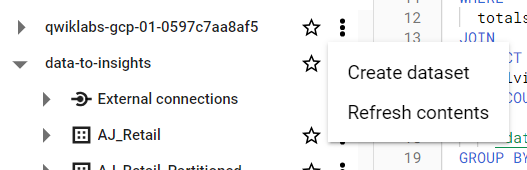

In the Create Dataset dialog:
For Dataset ID, type ecommerce.
Leave the other values at their defaults.
Click Create dataset.

# Task 4. Select a BigQuery ML model type and specify options
Now that you have your initial features selected, you are now ready to create your first ML model in BigQuery.

There are the two model types to choose from:

| Model       | Model Type     | Label Data Type                              | Example                                                      |
|-------------|----------------|----------------------------------------------|--------------------------------------------------------------|
| Forecasting | linear_reg     | Numeric value (typically an integer or floating point) | Forecast sales figures for next year given historical sales data. |
| Classification | logistic_reg | 0 or 1 for binary classification            | Classify an email as spam or not spam given the context.      |


What model type should you choose that will buy or won't buy?

Classification model (like logistic_reg etc.)


1. Enter the following query to create a model and specify model options:

In [ ]:
CREATE OR REPLACE MODEL `ecommerce.classification_model`
OPTIONS
(
model_type='logistic_reg',
labels = ['will_buy_on_return_visit']
)
AS

#standardSQL
SELECT
  * EXCEPT(fullVisitorId)
FROM

  # features
  (SELECT
    fullVisitorId,
    IFNULL(totals.bounces, 0) AS bounces,
    IFNULL(totals.timeOnSite, 0) AS time_on_site
  FROM
    `data-to-insights.ecommerce.web_analytics`
  WHERE
    totals.newVisits = 1
    AND date BETWEEN '20160801' AND '20170430') # train on first 9 months
  JOIN
  (SELECT
    fullvisitorid,
    IF(COUNTIF(totals.transactions > 0 AND totals.newVisits IS NULL) > 0, 1, 0) AS will_buy_on_return_visit
  FROM
      `data-to-insights.ecommerce.web_analytics`
  GROUP BY fullvisitorid)
  USING (fullVisitorId)
;

2. Next, click Run to train your model.
Wait for the model to train (5 - 10 minutes).

Note: You cannot feed all of your available data to the model during training since you need to save some unseen data points for model evaluation and testing. To accomplish this, add a WHERE clause condition is being used to filter and train on only the first 9 months of session data in your 12 month dataset.

After your model is trained, you will see the message "This statement created a new model named qwiklabs-gcp-xxxxxxxxx:ecommerce.classification_model".

3. Click Go to model.
Look inside the ecommerce dataset and confirm classification_model now appears.

Next, you will evaluate the performance of the model against new unseen evaluation data.

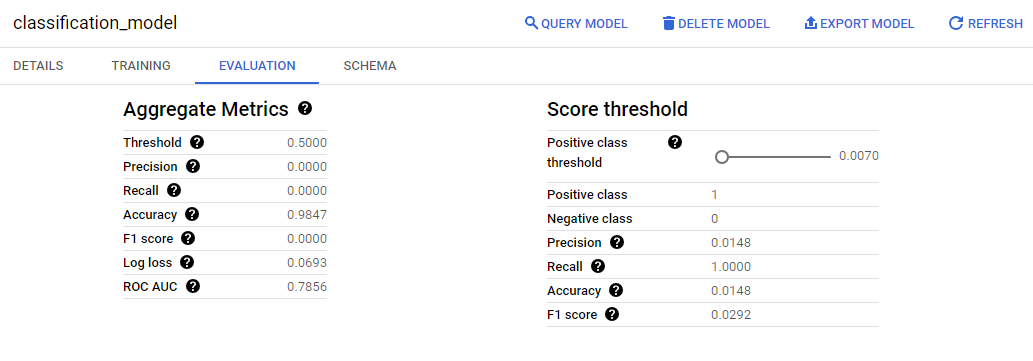

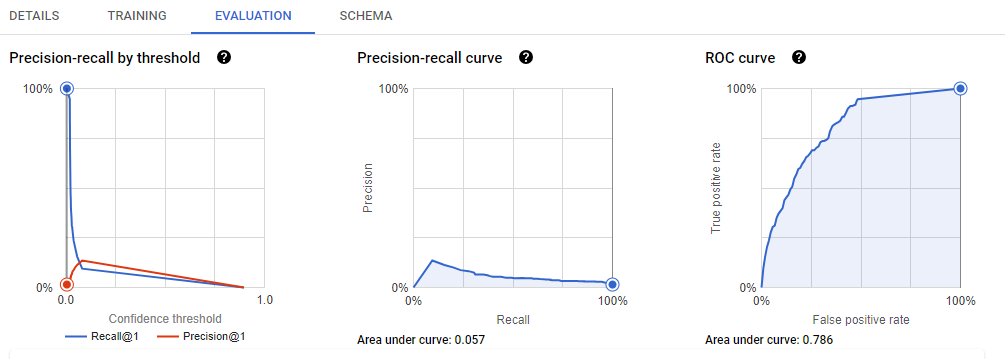

# Task 5. Evaluate classification model performance
Select your performance criteria
For classification problems in ML, you want to minimize the False Positive Rate (predict that the user will return and purchase and they don't) and maximize the True Positive Rate (predict that the user will return and purchase and they do).

This relationship is visualized with a ROC (Receiver Operating Characteristic) curve like the one shown here, where you try to maximize the area under the curve or AUC:

In BigQuery ML, roc_auc is simply a queryable field when evaluating your trained ML model.

Now that training is complete, you can evaluate how well the model performs by running this query using ML.EVALUATE:

In [ ]:
SELECT
  roc_auc,
  CASE
    WHEN roc_auc > .9 THEN 'good'
    WHEN roc_auc > .8 THEN 'fair'
    WHEN roc_auc > .7 THEN 'not great'
  ELSE 'poor' END AS model_quality
FROM
  ML.EVALUATE(MODEL ecommerce.classification_model,  (

SELECT
  * EXCEPT(fullVisitorId)
FROM

  # features
  (SELECT
    fullVisitorId,
    IFNULL(totals.bounces, 0) AS bounces,
    IFNULL(totals.timeOnSite, 0) AS time_on_site
  FROM
    `data-to-insights.ecommerce.web_analytics`
  WHERE
    totals.newVisits = 1
    AND date BETWEEN '20170501' AND '20170630') # eval on 2 months
  JOIN
  (SELECT
    fullvisitorid,
    IF(COUNTIF(totals.transactions > 0 AND totals.newVisits IS NULL) > 0, 1, 0) AS will_buy_on_return_visit
  FROM
      `data-to-insights.ecommerce.web_analytics`
  GROUP BY fullvisitorid)
  USING (fullVisitorId)

));

You should see the following result:

| Row | roc_auc | model_quality |
|-----|---------|---------------|
| 1   | 0.724588| not great     |

After evaluating your model you get a roc_auc of 0.72, which shows that the model has not great predictive power. Since the goal is to get the area under the curve as close to 1.0 as possible, there is room for improvement.

# Task 6. Improve model performance with feature engineering
As was hinted at earlier, there are many more features in the dataset that may help the model better understand the relationship between a visitor's first session and the likelihood that they will purchase on a subsequent visit.

Add some new features and create a second machine learning model called classification_model_2:
- How far the visitor got in the checkout process on their first visit
- Where the visitor came from (traffic source: organic search, referring site etc.)
- Device category (mobile, tablet, desktop)
- Geographic information (country)

1. Create this second model by running the below query:

In [ ]:
CREATE OR REPLACE MODEL `ecommerce.classification_model_2`
OPTIONS
  (model_type='logistic_reg', labels = ['will_buy_on_return_visit']) AS

WITH all_visitor_stats AS (
SELECT
  fullvisitorid,
  IF(COUNTIF(totals.transactions > 0 AND totals.newVisits IS NULL) > 0, 1, 0) AS will_buy_on_return_visit
  FROM `data-to-insights.ecommerce.web_analytics`
  GROUP BY fullvisitorid
)

# add in new features
SELECT * EXCEPT(unique_session_id) FROM (

  SELECT
      CONCAT(fullvisitorid, CAST(visitId AS STRING)) AS unique_session_id,

      # labels
      will_buy_on_return_visit,

      MAX(CAST(h.eCommerceAction.action_type AS INT64)) AS latest_ecommerce_progress,

      # behavior on the site
      IFNULL(totals.bounces, 0) AS bounces,
      IFNULL(totals.timeOnSite, 0) AS time_on_site,
      totals.pageviews,

      # where the visitor came from
      trafficSource.source,
      trafficSource.medium,
      channelGrouping,

      # mobile or desktop
      device.deviceCategory,

      # geographic
      IFNULL(geoNetwork.country, "") AS country

  FROM `data-to-insights.ecommerce.web_analytics`,
     UNNEST(hits) AS h

    JOIN all_visitor_stats USING(fullvisitorid)

  WHERE 1=1
    # only predict for new visits
    AND totals.newVisits = 1
    AND date BETWEEN '20160801' AND '20170430' # train 9 months

  GROUP BY
  unique_session_id,
  will_buy_on_return_visit,
  bounces,
  time_on_site,
  totals.pageviews,
  trafficSource.source,
  trafficSource.medium,
  channelGrouping,
  device.deviceCategory,
  country
);

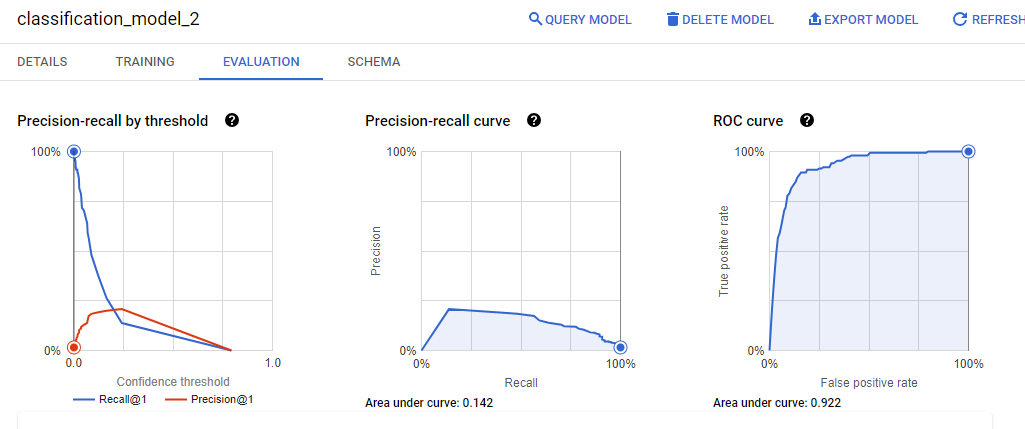

2. Evaluate this new model to see if there is better predictive power by running the below query:

In [ ]:
#standardSQL
SELECT
  roc_auc,
  CASE
    WHEN roc_auc > .9 THEN 'good'
    WHEN roc_auc > .8 THEN 'fair'
    WHEN roc_auc > .7 THEN 'not great'
  ELSE 'poor' END AS model_quality
FROM
  ML.EVALUATE(MODEL ecommerce.classification_model_2,  (

WITH all_visitor_stats AS (
SELECT
  fullvisitorid,
  IF(COUNTIF(totals.transactions > 0 AND totals.newVisits IS NULL) > 0, 1, 0) AS will_buy_on_return_visit
  FROM `data-to-insights.ecommerce.web_analytics`
  GROUP BY fullvisitorid
)

# add in new features
SELECT * EXCEPT(unique_session_id) FROM (

  SELECT
      CONCAT(fullvisitorid, CAST(visitId AS STRING)) AS unique_session_id,

      # labels
      will_buy_on_return_visit,

      MAX(CAST(h.eCommerceAction.action_type AS INT64)) AS latest_ecommerce_progress,

      # behavior on the site
      IFNULL(totals.bounces, 0) AS bounces,
      IFNULL(totals.timeOnSite, 0) AS time_on_site,
      totals.pageviews,

      # where the visitor came from
      trafficSource.source,
      trafficSource.medium,
      channelGrouping,

      # mobile or desktop
      device.deviceCategory,

      # geographic
      IFNULL(geoNetwork.country, "") AS country

  FROM `data-to-insights.ecommerce.web_analytics`,
     UNNEST(hits) AS h

    JOIN all_visitor_stats USING(fullvisitorid)

  WHERE 1=1
    # only predict for new visits
    AND totals.newVisits = 1
    AND date BETWEEN '20170501' AND '20170630' # eval 2 months

  GROUP BY
  unique_session_id,
  will_buy_on_return_visit,
  bounces,
  time_on_site,
  totals.pageviews,
  trafficSource.source,
  trafficSource.medium,
  channelGrouping,
  device.deviceCategory,
  country
)
));

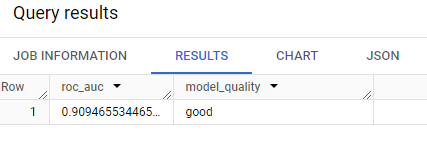

With this new model you now get a roc_auc of 0.91 which is significantly better than the first model.

Now that you have a trained model, time to make some predictions.

# Task 7. Predict which new visitors will come back and purchase
Next you will write a query to predict which new visitors will come back and make a purchase.

Run the prediction query below which uses the improved classification model to predict the probability that a first-time visitor to the Google Merchandise Store will make a purchase in a later visit:

In [ ]:
SELECT
*
FROM
  ml.PREDICT(MODEL `ecommerce.classification_model_2`,
   (

WITH all_visitor_stats AS (
SELECT
  fullvisitorid,
  IF(COUNTIF(totals.transactions > 0 AND totals.newVisits IS NULL) > 0, 1, 0) AS will_buy_on_return_visit
  FROM `data-to-insights.ecommerce.web_analytics`
  GROUP BY fullvisitorid
)

  SELECT
      CONCAT(fullvisitorid, '-',CAST(visitId AS STRING)) AS unique_session_id,

      # labels
      will_buy_on_return_visit,

      MAX(CAST(h.eCommerceAction.action_type AS INT64)) AS latest_ecommerce_progress,

      # behavior on the site
      IFNULL(totals.bounces, 0) AS bounces,
      IFNULL(totals.timeOnSite, 0) AS time_on_site,
      totals.pageviews,

      # where the visitor came from
      trafficSource.source,
      trafficSource.medium,
      channelGrouping,

      # mobile or desktop
      device.deviceCategory,

      # geographic
      IFNULL(geoNetwork.country, "") AS country

  FROM `data-to-insights.ecommerce.web_analytics`,
     UNNEST(hits) AS h

    JOIN all_visitor_stats USING(fullvisitorid)

  WHERE
    # only predict for new visits
    totals.newVisits = 1
    AND date BETWEEN '20170701' AND '20170801' # test 1 month

  GROUP BY
  unique_session_id,
  will_buy_on_return_visit,
  bounces,
  time_on_site,
  totals.pageviews,
  trafficSource.source,
  trafficSource.medium,
  channelGrouping,
  device.deviceCategory,
  country
)

)

ORDER BY
  predicted_will_buy_on_return_visit DESC;

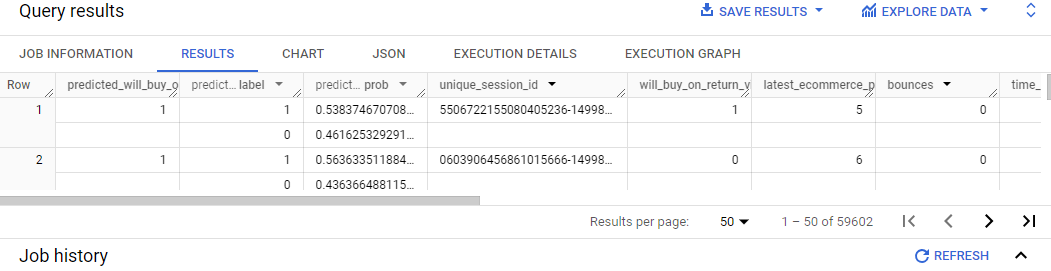

The predictions are made in the last 1 month (out of 12 months) of the dataset.

Your model will now output the predictions it has for those July 2017 ecommerce sessions. You can see three newly added fields:

- predicted_will_buy_on_return_visit: whether the model thinks the visitor will buy later (1 = yes)
- predicted_will_buy_on_return_visit_probs.label: the binary classifier for yes / no
- predicted_will_buy_on_return_visit_probs.prob: the confidence the model has in it's prediction (1 = 100%)

Results
- Of the top 6% of first-time visitors (sorted in decreasing order of predicted probability), more than 6% make a purchase in a later visit.
- These users represent nearly 50% of all first-time visitors who make a purchase in a later visit.
- Overall, only 0.7% of first-time visitors make a purchase in a later visit.
- Targeting the top 6% of first-time increases marketing ROI by 9x vs targeting them all!